# Political Tweets Analysis - Sentiment

In [1]:
import math
import pandas as pd
import numpy as np
import csv
import sys, os
import string
import re
import datetime
# Natural Language Processing
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import EnglishStemmer # load the stemmer module from NLTK
dataloc = '/Volumes/Seagate Backup Plus Drive/PoliTweet/TwitterData/'
import emoji

#### Loading Components for NLP

In [2]:
twtokenizer = TweetTokenizer()

In [3]:
punctuation = list(set(string.punctuation)) + ['…','’','...','—',':/','”','..', '“']

In [4]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should'] # Removed 'not','now', 'no','nor'

In [5]:
stopwords_short = ['the','an','a', ]

#### Reading in Tweets

In [6]:
fileList = pd.read_csv('masterFileList.csv')

In [7]:
HC_batch = fileList[(fileList['cleanCandidate'] == 'HillaryClinton') & (fileList['Year'] == 2016) \
                    & (fileList['Month'] == 5) & (fileList['Day'] == 31) & (fileList['Query'] == 'at')]

In [8]:
def readTwitterCSV(file):
    data = pd.DataFrame(list(csv.reader(open(file),skipinitialspace=True)))
    newCol = []
    counter = 0
    for word in data.iloc[0]:
        if word is None:
            word = 'None'+'_'+ str(counter)
            newCol.append(word)
            counter += 1
        else:
            newCol.append(word)
    
    data.columns = newCol
    
    data = data.drop(0)
    data.dropna(axis = 0)
    return data 

In [9]:
# Combine all @ Hillary Clinton Tweets for 1 Day
HC = pd.DataFrame()
for file in HC_batch.fileName:
    print(file)
    filePath =  dataloc + "/" + file
    temp = readTwitterCSV(filePath)
    # print(len(temp))
    # print(len(temp.columns))
    # print(temp.columns)
    HC = pd.concat([HC,temp])
HC = HC.reset_index()

[ BATCH -at,HillaryClinton-STATUS]2016.05.31.06.01.20
[ BATCH -at,HillaryClinton-STATUS]2016.05.31.06.46.15
[ BATCH -at,HillaryClinton-STATUS]2016.05.31.07.00.56
[ BATCH -at,HillaryClinton-STATUS]2016.05.31.07.15.46


#### Tokenizing & Pre-Processing Corpus

In [10]:
def clean_tweets(tweet):
    #tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()
    cleanWords = twtokenizer.tokenize(tweet)
    
    # Convert to Lowercase
    cleanWords = [t.lower() for t in cleanWords]
    
    # Convert Emoji's to Word Label
    cleanWords = [emoji.demojize(word) for word in cleanWords]
    

    # Normalize (remove punctuation)
    #Remove punctuation
    cleanWords = [word for word in cleanWords if word not in punctuation]
    
    # punc = string.punctuation
    # cleanWords = [t for t in cleanWords if t not in punc]
    # cleanWords = [re.sub('[^0-9a-z]', "", x) for x in cleanWords]
    
    # Remove Empty Vectors
    cleanWords = [x for x in cleanWords if x != '']
     
    # Remove StopWords
    # cleanWords = [word for word in cleanWords if word not in stopwords_short]
    cleanWords = [word for word in cleanWords if word not in stopwords]
    
    # Identify Digits & Convert to Num
    #cleanWords = [re.sub("\d+", "NUM", x) for x in cleanWords]
    
    # Remove all Web/URL References
    # Could be better to replace with 'URL'
    cleanWords = [word for word in cleanWords if word[0:3] != 'htt']
    
    # Stem Words
    #cleanWords = [stemmer.stem(x) for x in cleanWords] # call stemmer to stem the input
    
    # Remove Multiple Letters, Replace with only 3
    
    
    return cleanWords

In [11]:
# Tokenize & Clean Corpus
tokenList = [clean_tweets(i) for i in HC['statusText']]

#### Building Sentiment Model

In [12]:
# Can get ~ 10k Sentiment Labeled Tweets
from nltk.corpus import twitter_samples

In [13]:
# To download the Twitter Sentiment Files
# nltk.download('twitter_samples')

In [14]:
neg_tweets = twitter_samples.strings('negative_tweets.json')
pos_tweets = twitter_samples.strings('positive_tweets.json')

In [15]:
neg_tweets_clean = [clean_tweets(tweet) for tweet in neg_tweets]
pos_tweets_clean = [clean_tweets(tweet) for tweet in pos_tweets]

In [16]:
# Adding Label to Each Tweet
neg_tweets_labeled = list(zip(neg_tweets,['neg']*len(neg_tweets)))
pos_tweets_labeled = list(zip(pos_tweets,['pos']*len(pos_tweets)))

In [81]:
# Tokenize and Clean the Training Set [If using the NLTK, remove :( as a Feature)?]
neg_tweets_clean = [(clean_tweets(tweet),sent) for (tweet,sent) in neg_tweets_labeled]
pos_tweets_clean = [(clean_tweets(tweet),sent) for (tweet,sent) in pos_tweets_labeled]

In [84]:
# Build combined Pos/Neg Tweet Set with Labels (What about Neutral?)
train = neg_tweets_clean + pos_tweets_clean

In [86]:
train[0]

(['hopeless', 'tmr', ':('], 'neg')

#### Train Model

Source: http://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/

In [22]:
# Get Term Frequency for All Negative Tweets
TF_neg = getTermFreq(neg_tweets_clean)
u_theta_neg = genUniLM(TF_neg)

Total Probability:  1.0000000000002178


/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [37]:
# createSmoothedProbability == Words in TF_1 and not in TF_0
pSmooth_neg = calc_pSmoothAdditive(list(TF_pos.keys()), u_theta_neg, 0.1)

In [23]:
# Get Term Frequency for All Positive Tweets
TF_pos = getTermFreq(pos_tweets_clean)
u_theta_pos = genUniLM(TF_pos)

Total Probability:  0.9999999999995887


/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [38]:
# createSmoothedProbability == Words in TF_1 and not in TF_0
pSmooth_pos = calc_pSmoothAdditive(list(TF_neg.keys()), u_theta_pos, 0.1)

In [39]:
# Create Term Freq for Whole Training Corpus, Maybe Filter Later (Cont = Controled Vocabulary)
TF_cont = {}
for word in set(list(TF_pos.keys())+list(TF_neg.keys())):
    try: 
        p = TF_pos[word]
    except KeyError: 
        p = 0
    try: 
        n = TF_neg[word]
    except KeyError: 
        n = 0
    TF_cont[word] = p+n

In [27]:
# sampleKeys(TF_cont)
TF_cont['suck']

8

In [28]:
# Estimate Naive Bayes classifier, Need to Smooth Before Implementation
navBayes = {}
for word in TF_cont:
    try:
        logRatio = math.log(u_theta_pos['p'].ix[word]/u_theta_neg['p'].ix[word])
    except KeyError:
        logRatio = 0
    navBayes[word] = logRatio

In [29]:
navBayesDF = pd.DataFrame.from_dict(navBayes, orient = "index")
navBayesDF.columns = ['logRatio']
navBayesDF = navBayesDF.sort('logRatio', ascending = False)

/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [30]:
navBayesDF[0:10]

,logRatio
:),7.467538
bam,3.731222
community,3.348230
goodnight,3.082526
arrived,3.022807
glad,3.015085
opportunities,2.891471
appreciate,2.891471
loves,2.760443
followers,2.719621


In [31]:
total = len(neg_tweets_clean) + len(pos_tweets_clean)
prob_neg = len(neg_tweets_clean)/total
prob_pos = len(pos_tweets_clean)/total
total, prob_pos, prob_neg

(10000, 0.5, 0.5)

In [32]:
# Old Var Names
obs = len(dataDF_cont.ix[dataDF_cont.Class])
prob1 = len(dataDF_cont.ix[dataDF_cont.Class == 1])/obs
prob0 = len(dataDF_cont.ix[dataDF_cont.Class == 0])/obs
obs, prob1, prob0

NameError: name 'dataDF_cont' is not defined

In [43]:
def calcfX_NBLin(tokenlist, prob1, prob0, pSmooth_1, pSmooth_0):
    X = 0
    for word in tokenlist:
        try:
            pX_y1 = pSmooth_1.ix[word]
        except KeyError:
            pX_y1 = 1
        try:
            pX_y0 = pSmooth_0.ix[word]
        except KeyError:
            pX_y0 = 1
            
        x = math.log(pX_y1)-math.log(pX_y0)
        X = X + x
    fX = math.log(prob1/prob0) + X

    return fX

In [44]:
fX = [calcfX_NBLin(tweet, prob_pos, prob_neg, pSmooth_pos, pSmooth_neg) for tweet in tokenList]

In [60]:
fx_sgn = [1 if tweet >= 0 else 0 for tweet in fX]

In [63]:
len(fX)

53263

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
fX[0]

2.2928135051786667

In [47]:
tokenList[0]

['1st',
 'look',
 '@hillaryclinton',
 'new',
 'military',
 'family',
 'policy',
 'paper',
 'including',
 'new',
 'leave',
 'plans',
 'pcs',
 'flexibility']

In [ ]:
metrics.accuracy_score()

In [33]:
def sampleKeys(dict):
    return list(TF_neg.keys())[0:10]

In [14]:

# Fit Model to Training Set
# Naive Bayes
classifier = nltk.NaiveBayesClassifier.train(training_set)


#### Predict

In [ ]:
# Tokenize and Clean the Test Set
tokenList

# Predict Positive/Negative Sentiment



#### Sum Pos/Neg Over Day Per Candidate

#### Evaluate Model Results Against Validation Set

In [24]:
HC_batch = fileList[(fileList['cleanCandidate'] == 'HillaryClinton') & (fileList['Year'] == 2016) \
                    & (fileList['Month'] == 6) & (fileList['Day'] == 1) & (fileList['Query'] == 'at')]

In [29]:
# Combine all @ Hillary Clinton Tweets for 1 Day
HC_20160601 = pd.DataFrame()
for file in HC_batch.fileName:
    print(file)
    filePath =  dataloc + "/" + file
    temp = readTwitterCSV(filePath)
    # print(len(temp))
    # print(len(temp.columns))
    # print(temp.columns)
    HC_20160601 = pd.concat([HC_20160601,temp])
HC_20160601 = HC_20160601.reset_index()

[ BATCH -at,HillaryClinton-STATUS]2016.06.01.06.01.21
[ BATCH -at,HillaryClinton-STATUS]2016.06.01.06.46.36
[ BATCH -at,HillaryClinton-STATUS]2016.06.01.07.01.45
[ BATCH -at,HillaryClinton-STATUS]2016.06.01.07.16.18
[ BATCH -at,HillaryClinton-STATUS]2016.06.01.07.30.55
[ BATCH -at,HillaryClinton-STATUS]2016.06.01.07.45.49


In [40]:
HC_val = pd.DataFrame(HC_20160601.loc[0:50,'statusText'])
HC_val['sent'] = 'O'

In [ ]:
# Build a validation set interactively w/ the User
for i in range(0,len(HC_val)):
    print(HC_val.loc[i,'statusText'])
    eval = input('And the sentiment is? ')
    HC_val.loc[i,'sent'] = eval

In [49]:
# Export Validation to CSV
HC_val.to_csv('validation_set.csv')

In [47]:
HC_val_clean = HC_val.loc[HC_val.sent != 'X',:] # Removed "unclear" tweets

In [ ]:
# Train to Find Junk Tweets? The ones I threw out bc were '@user @user2 URL' or other totally undisipherable

In [48]:
HC_val_clean

,statusText,sent
1,RT @Tjaisb: @KrisParonto @HillaryClinton @13ho...,N
2,#ICYMI: Confident @HillaryClinton tells @NYMag...,P
4,RT @edvotes: How we treat educators matters. P...,P
10,RT @HillaryPix: #ImWithHer #HillaryClinton #Sh...,P
16,@realDonaldTrump gave 100% collected funds to ...,N
17,Seize San Bernardino shooter insurance https:/...,N
18,RT @bfraser747: I've been asking myself everyd...,N
23,First: the @latimes. Now: @JerryBrownGov. Her...,P
24,@Forbes WHAT E-MAIL SCANDAL?. It is all going ...,P
25,@laughingliberal @Story27368218 @Occuping I'm...,N


Predict Sentiment on Validation Set


In [51]:
# Load Validation Set
HC_val = pd.read_csv('/Users/hopeemac/Documents/Code/PoliTweet/validation_set.csv')

In [57]:
# Format Val Set
HC_val_clean = HC_val.loc[HC_val.sent != 'X',:] # Removed "unclear" tweets

HC_val_clean.loc[HC_val.sent == 'P','sent'] = 1 # Removed "unclear" tweets

HC_val_clean.loc[HC_val.sent == 'N','sent'] = 0 # Removed "unclear" tweets
HC_val_clean
# len(HC_val_clean)

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Unnamed: 0,statusText,sent
1,1,RT @Tjaisb: @KrisParonto @HillaryClinton @13ho...,0
2,2,#ICYMI: Confident @HillaryClinton tells @NYMag...,1
4,4,RT @edvotes: How we treat educators matters. P...,1
10,10,RT @HillaryPix: #ImWithHer #HillaryClinton #Sh...,1
16,16,@realDonaldTrump gave 100% collected funds to ...,0
17,17,Seize San Bernardino shooter insurance https:/...,0
18,18,RT @bfraser747: I've been asking myself everyd...,0
23,23,First: the @latimes. Now: @JerryBrownGov. Her...,1
24,24,@Forbes WHAT E-MAIL SCANDAL?. It is all going ...,1
25,25,@laughingliberal @Story27368218 @Occuping I'm...,0


In [66]:
# Prepare Validation Ground Truth
tokenList_HC_val = [clean_tweets(tweet) for tweet in HC_val_clean['statusText']]
y_HC_val = [sent for sent in HC_val_clean['sent']]

In [64]:
# Predict Using Classifier
fX = [calcfX_NBLin(tweet, prob_pos, prob_neg, pSmooth_pos, pSmooth_neg) for tweet in tokenList_HC_val]
yHat_HC_val = [1 if tweet >= 0 else 0 for tweet in fX]

In [71]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [75]:
print('Accuracy: %.2f' % accuracy_score(y_HC_val,yHat_HC_val))
print('Precision: %.2f' % precision_score(y_HC_val,yHat_HC_val))
print('Recall: %.2f' % recall_score(y_HC_val,yHat_HC_val))
print('F1: %.2f' % f1_score(y_HC_val,yHat_HC_val))

Accuracy: 0.57
Precision: 0.46
Recall: 0.67
F1: 0.55


## Methods

In [18]:
def getTermFreq(textList):
    TF = {}
    for row in textList:
        #print(row)
        for word in row:
            # print(word)
            if word in TF:
                TF[word] += 1
            else:
                TF[word] = 1
    return TF

In [19]:
def getDocFreq(textlist):
    DF = {}
    for row in textlist:
        for word in set(row):
            # print(word)
            if word in DF:
                DF[word] += 1
            else:
                DF[word] = 1
    return DF

In [20]:
def create_countVectors(tokens):
    doc_TF = {}
    for token in tokens:
        if token in doc_TF:
            doc_TF[token] += 1
        else:
            doc_TF[token] = 1
    return doc_TF

In [21]:
# Unigram Language Model
def genUniLM(TF):
    u_theta = pd.DataFrame.from_dict(TF, orient = "index")
    u_theta.columns = ['TF']
    # u_theta.sort('TF', ascending = False)[0:10]
    # Total Number of Words in Training Corpus
    nWords = u_theta['TF'].sum()
    nWords
    # Number of Unique Words in Training Corpus
    vSize = len(u_theta['TF'])
    vSize
    # Calculate Probabilty of Each Word by TTF/N
    u_theta['p'] = u_theta/nWords
    u_theta = u_theta.sort('TF', ascending = False)
    # Check that Probability Sums to 1
    print("Total Probability: ",u_theta['p'].sum())
    return u_theta

In [36]:
def calc_pSmoothAdditive(tokenList, u_theta, d):
    
    vSize_train = len(u_theta)
    nWords_train = sum(u_theta['TF'])
    
    unseenWords = list(set(tokenList) - set(u_theta.index))
    #print(len(unseenWords))
    if len(unseenWords) == 0:
        return u_theta['p']
    else:
        # Build Series with all unique words in training set + unseen words from test document
        pSmooth = u_theta['TF'].append(pd.Series(([0]*len(unseenWords)), index = unseenWords))
        nWords_train += len(unseenWords)
        vSize_train += len(unseenWords)
        f = lambda x: ((x + d) / (nWords_train + d*vSize_train))
        pSmooth = pSmooth.map(f)
        return pSmooth

In [112]:
TF_unclean = getTermFreq(tokenList_unclean)

Plotting Word Frequency

In [117]:
TF_DF_unclean = pd.DataFrame.from_dict(TF_unclean, orient = 'index')
TF_DF_unclean.columns = ['TF']
TF_DF_unclean.sort_values(by = 'TF', ascending = False, inplace = True)

In [121]:
TF_DF_unclean['Rank'] = range(1,len(TF_DF_unclean)+1)

In [122]:
TF_DF_unclean[0:10]

,TF,Rank
@HillaryClinton,73435,1
.,55560,2
:,54143,3
RT,44352,4
the,23262,5
to,21932,6
",",20945,7
of,16572,8
!,15144,9
is,14120,10


In [113]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

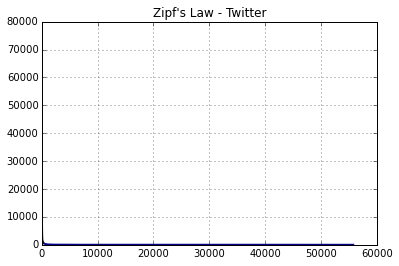

In [126]:
plt.figure()
plt.plot(TF_DF_unclean['Rank'],TF_DF_unclean['TF'], 
          color='darkblue', 
          linewidth = 2)
plt.grid(True)
plt.title("Zipf's Law - Twitter")
plt.show()

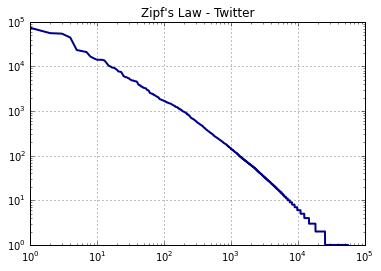

In [124]:
plt.figure()
plt.loglog(TF_DF_unclean['Rank'],TF_DF_unclean['TF'], 
          color='darkblue', 
          linewidth = 2)
plt.grid(True)
plt.title("Zipf's Law - Twitter")
plt.show()

In [40]:
pattern = re.compile(':.+:')
if pattern.match(e):
    print('emoji')
#re.find(':.:',e)

emoji


In [44]:
list(TF.keys())[0:10]

['celebration',
 'higher',
 '@awizardindallas',
 '1968',
 'srop',
 'bud',
 'اعينكم',
 '#han',
 'memers',
 '@shwahkram']

In [158]:
TF['high']

141

In [46]:
# Get emoji counts
TF_Emojis = {k:v for k, v in TF.items() if pattern.match(k)}
# len(TF_XMore)

In [48]:
len(TF_Emojis)

294

In [ ]:
# Remove Stop Words (From 1-grams)
def removeStopwords(text, stopwordList):
    newList = [t for t in text if t not in stopwordList]
    return newList

In [49]:
topWords = pd.DataFrame.from_dict(TF_Emojis, orient = 'index')
topWords.columns = ['TF']
topWords.sort_values(ascending = False, inplace = True, by = 'TF')

In [52]:
topWords[topWords.TF > 2]

,TF
:face_with_tears_of_joy:,533
:pistol:,167
:heavy_black_heart:,151
:clapping_hands_sign:,150
:double_exclamation_mark:,149
:party_popper:,149
:blue_heart:,143
:collision_symbol:,135
:fire:,135
:thumbs_up_sign:,119


In [122]:
emoji.emojize(':black_question_mark_ornament:')

'❓'

In [56]:
# Review Tweets Containing Specific Emoji
emojiExamples = ]k:v for k, v in corpus.items() if emoji.emojize(':face_with_tears_of_joy:') in v}

In [62]:
emojiExamples = [tweet for tweet in HC['statusText'] if emoji.emojize(':face_with_tears_of_joy:') in tweet]

In [63]:
emojiExamples

['@naelli222 @DavidAFrench @realDonaldTrump @HillaryClinton Texas??? 😂😂😂😂😂😂😂😂😂😂😂😂',
 '@TSalommy @NBCNews @meetthepress @BernieSanders @HillaryClinton typical drumpf follower  \\big dumb sheep\\" speaks volumes 2nd grade level 😂😂"',
 'RT @An0nKn0wledge: Too Awesome!  #ManEnough4Hillary Do YOU #FeelTheBern yet @HillaryClinton? 😂😂😂 #LOL. #HillaryATroll2016 https://t.co/KXqy…',
 'RT @ojscx: Send me a picture with @HillaryClinton having this many supporters 😂😂 #DownWithHillary #FeelTheBern https://t.co/UcaJm0dcQA',
 '@shami_here @ShahramSR @HillaryClinton @BBhuttoZardari @HamidMirGEO in fact she said ISKI maaa mar gayi iska NANA mar gaya ISKO vote de dou😂',
 '@therealshycat @HillaryClinton 😂Haha! Yes!!',
 '@johnpodesta @HillaryClinton @washingtonpost criticising @realDonaldTrump would Help him more to get pubilcity..  Be careful madam.. 😂😂',
 'RT @ojscx: Send me a picture with @HillaryClinton having this many supporters 😂😂 #DownWithHillary #FeelTheBern https://t.co/UcaJm0dcQA',
 'RT @ojscx:

In [60]:
corpus['737824642740555777']

['@hillaryclinton',
 'when',
 'trump',
 "isn't",
 'lying',
 'on',
 'natl',
 'tv',
 'or',
 'at',
 'rallies',
 'he',
 'likes',
 '2',
 'talk',
 'about',
 'ratings',
 'how',
 'rich',
 'he',
 'is',
 'and',
 'how',
 'much',
 'he',
 'loves',
 'himself']

In [47]:
len(TF.keys())

36124

In [160]:
# Get Vocabulary w/ Over 20 Occurances
TF_XMore = {k:v for k, v in TF.items() if v > 2}
len(TF_XMore)

14217

In [43]:
topWords = pd.DataFrame.from_dict(TF_XMore, orient = 'index')
topWords.columns = ['TF']
topWords.sort_values(ascending = False, inplace = True, by = 'TF')

In [44]:
topWords[0:20]

,TF
@hillaryclinton,74351
rt,44358
to,22669
of,16956
is,14953
you,13086
for,12403
@realdonaldtrump,10529
in,10134
and,9877


## Topic Modeling Tweets

In [48]:
! pip install lda

    100% |████████████████████████████████| 389kB 922kB/s 
    100% |████████████████████████████████| 102kB 5.2MB/s 
You are using pip version 8.0.3, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
import lda

In [38]:
import lda.datasets

In [39]:
# Function to remove all words not in wordlist
def keepWords(text, wordList):
    newList = [t for t in text if t in wordList]
    return newList

In [100]:
# Filter Vocabulary to Only Words w/ Greater than 5 Occurances (Removing Tail Words)
TF = getTermFreq(tokenList)
# Get Vocabulary w/ Over 5 Occurances
TF_XMore = {k:v for k, v in TF.items() if v > 5}
len(TF_XMore)
words_XMore = list(TF_XMore.keys())
tokenList = [keepWords(i, words_XMore) for i in tokenList]

In [101]:
corpus = {HC.loc[i,'statusId']: tokenList[i] for i in range(0,len(tokenList))}

##### Reuteres Sample

In [55]:
X = lda.datasets.load_reuters()

In [56]:
X.shape

(395, 4258)

In [143]:
vocab = lda.datasets.load_reuters_vocab()

In [ ]:
titles = lda.datasets.load_reuters_titles()

In [178]:
start = datetime.datetime.now()
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
runtime = datetime.datetime.now()-start
print(str(runtime))

Topic 0: british churchill sale million major letters west britain
Topic 1: church government political country state people party against
Topic 2: elvis king fans presley life concert young death
Topic 3: yeltsin russian russia president kremlin moscow michael operation
Topic 4: pope vatican paul john surgery hospital pontiff rome
Topic 5: family funeral police miami versace cunanan city service
Topic 6: simpson former years court president wife south church
Topic 7: order mother successor election nuns church nirmala head
Topic 8: charles prince diana royal king queen parker bowles
Topic 9: film french france against bardot paris poster animal
Topic 10: germany german war nazi letter christian book jews
Topic 11: east peace prize award timor quebec belo leader
Topic 12: n't life show told very love television father
Topic 13: years year time last church world people say
Topic 14: mother teresa heart calcutta charity nun hospital missionaries
Topic 15: city salonika capital buddhist c

##### Running w/ Political Tweets

Functions to Generate a Document-Term Matrix

In [41]:
def create_countVectors(tokens):
    doc_TF = {}
    for token in tokens:
        if token in doc_TF:
            doc_TF[token] += 1
        else:
            doc_TF[token] = 1
    return doc_TF

In [42]:
def createDTM(corpus):
    dtmHASH = {}
    for key in corpus.keys():
        dtmHASH[key] = create_countVectors(corpus[key])
    return dtmHASH

In [102]:
dtm = createDTM(corpus)

Transform the DTM to Matrix to Run in LDA Function

In [103]:
dtm_df = pd.DataFrame.from_dict(dtm, orient = 'index')

In [104]:
dtm_df.fillna(0, inplace = True)

In [105]:
dtm_df = dtm_df.astype(int)

In [106]:
dtm_matrix = dtm_df.as_matrix()

In [107]:
model = lda.LDA(n_topics=40, n_iter=1500, random_state=1)

In [108]:
start = datetime.datetime.now()
model.fit(dtm_matrix)  # model.fit_transform(X) is also available
runtime = datetime.datetime.now()-start
print(str(runtime))

0:16:06.887251


In [109]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 10
vocab = dtm_df.columns

In [110]:
# Print Top N Words in Each Topic
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ', '.join(topic_words)))

Topic 0: @hillaryclinton, rt, hillary, #imwithher, not, go, stand, #caprimary, 10, 1992
Topic 1: @hillaryclinton, rt, liar, one, not, lies, @neilturner_, she's, prison, please
Topic 2: @hillaryclinton, rt, vote, record, still, trump, #imwithher, 🇸, 🇺, important
Topic 3: trump, not, now, rt, even, he's, change, @hillaryclinton, climate, california
Topic 4: @hillaryclinton, rt, @berniesanders, @jerrybrowngov, california, @politico, #feelthebern, #caprimary, #imwithher, new
Topic 5: @hillaryclinton, rt, support, families, need, let's, give, words, service, deserve
Topic 6: @hillaryclinton, rt, no, @fbi, @davidshuster, clinton, give, state, interview, not
Topic 7: @hillaryclinton, benghazi, @realdonaldtrump, #benghazi, 4, rt, die, killed, don't, americans
Topic 8: @hillaryclinton, don't, no, get, one, us, rt, think, right, time
Topic 9: @hillaryclinton, rt, @berniesanders, email, allowed, it's, saying, democrats, see, ever
Topic 10: @realdonaldtrump, war, rt, commander-in-chief, prisoners,

### Opposition Acknowledgement
Identifying the percentage of Tweets containing a reference to a political opponent